In [239]:
import numpy as np
import pandas as pd 
import nltk 
import string

In [240]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 800)
df = pd.read_csv('subset_headlines.csv', parse_dates=['scraped_at'])
df[['headline_1_title', 'headline_1_url']] = df['headline_1'].str.split('https://', n=1, expand=True)
df[['headline_2_title', 'headline_2_url']] = df['headline_2'].str.split('https://', n=1, expand=True)
df[['headline_3_title', 'headline_3_url']] = df['headline_3'].str.split('https://', n=1, expand=True)

df.drop(['headline_1', 'headline_2', 'headline_3'], axis=1, inplace=True)
print(df.head())

                          org                 scraped_at                                   headline_1_title                                     headline_1_url                                   headline_2_title                                     headline_2_url                                   headline_3_title                                     headline_3_url
0   https://www.economist.com 2024-11-28 05:39:57.350818                Elon Musk’s xAI goes after OpenAI,   www.economist.com/business/2024/11/27/elon-mus...  Does Donald Trump have unlimited authority to ...  www.economist.com/united-states/2024/11/27/doe...                 Peace in Lebanon is just a start,   www.economist.com/leaders/2024/11/27/peace-in-...
1  https://www.lemonde.fr/en/ 2024-11-28 05:39:55.247174  With her latest production, French theater gia...  www.lemonde.fr/en/culture/article/2024/11/28/w...  Tens of thousands in Lebanon head home as Isra...  www.lemonde.fr/en/international/article/2024/1...  Biden admini

In [241]:
for i in ['headline_1_url', 'headline_2_url', 'headline_3_url']:
    df[i] = 'https://' + df[i].astype(str)
melted = pd.melt(df, id_vars=['org', 'scraped_at'], value_vars=['headline_1_title', 'headline_2_title', 'headline_3_title'], var_name='headline_type', value_name='headline')
print(df.shape)
print(melted.shape)

(100, 8)
(300, 4)


In [242]:
melted_urls = pd.melt(df, id_vars=['org', 'scraped_at'], value_vars=['headline_1_url', 'headline_2_url', 'headline_3_url'], var_name='headline_url', value_name='url')
melted['url'] = melted_urls['url']
final_df = melted[['headline', 'url', 'org', 'scraped_at', 'headline_type']]
final_df['headline_type'] = final_df['headline_type'].str.extract(r'headline_(\d+)_title')

print(final_df.head(20))
print(final_df.shape)

                                             headline                                                url                         org                 scraped_at headline_type
0                 Elon Musk’s xAI goes after OpenAI,   https://www.economist.com/business/2024/11/27/...   https://www.economist.com 2024-11-28 05:39:57.350818             1
1   With her latest production, French theater gia...  https://www.lemonde.fr/en/culture/article/2024...  https://www.lemonde.fr/en/ 2024-11-28 05:39:55.247174             1
2   Air raid alert across Ukraine as multiple expl...     https://www.bbc.com/news/articles/cwy15lp21l3o         https://www.bbc.com 2024-11-28 05:39:54.460652             1
3   ‘Absolutely terrifying’: Israel pounds north G...  https://www.aljazeera.com/news/liveblog/2024/1...   https://www.aljazeera.com 2024-11-28 05:39:53.667695             1
4     Trump wastes no time in reigniting trade wars,   https://www.economist.com/finance-and-economic...   https://www.economist.c

In [243]:
# final_df['org'] = final_df['org'].str.extract(r'https?:\/\/(?:www\.)?([a-zA-Z0-9-]+)')
# print(final_df.head(5))
# final_df.to_dict('records')

In [1]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
import re

def remove_punct(text):
    quotes = {''', ''', '"', '"', '′', '`', "'"}
    for q in quotes:
        text = text.replace(q, '')
    no_punct = "".join([c for c in text if c not in string.punctuation])
    return no_punct

def remove_stopwords(text):
    words = word_tokenize(text)
    without_stopwords = " ".join([w for w in words if w.lower() not in stopwords.words('english')])
    return without_stopwords

final_df['headline'] = final_df['headline'].apply(lambda x: remove_stopwords(x))
final_df['headline'] = final_df['headline'].apply(lambda x: remove_punct(x))
final_df['headline'] = final_df['headline'].apply(lambda x: remove_stopwords(x))

print(final_df.head(5))

NameError: name 'nltk' is not defined

In [245]:
from collections import Counter

all_headlines = ''.join(final_df['headline'])     
words_counts = Counter(word_tokenize(all_headlines))
most_common_words = words_counts.most_common(20)
print(most_common_words)

[('’', 77), ('Trump', 45), ('Gaza', 26), ('Ukraine', 24), ('‘', 22), ('Israel', 19), ('US', 19), ('Lebanon', 14), ('says', 14), ('Donald', 13), ('Harris', 13), ('ceasefire', 11), ('election', 11), ('Hezbollah', 10), ('war', 9), ('new', 9), ('Musk', 8), ('truce', 7), ('Gaetz', 7), ('attacks', 7)]


In [246]:
most_common_words_df = pd.DataFrame(most_common_words, columns=['word', 'count'])
most_common_words_df.drop(0, inplace=True)
most_common_words_df.drop(4, inplace=True)
#most_common_words_df.drop(8, inplace=True)


print(most_common_words_df)


         word  count
1       Trump     45
2        Gaza     26
3     Ukraine     24
5      Israel     19
6          US     19
7     Lebanon     14
8        says     14
9      Donald     13
10     Harris     13
11  ceasefire     11
12   election     11
13  Hezbollah     10
14        war      9
15        new      9
16       Musk      8
17      truce      7
18      Gaetz      7
19    attacks      7


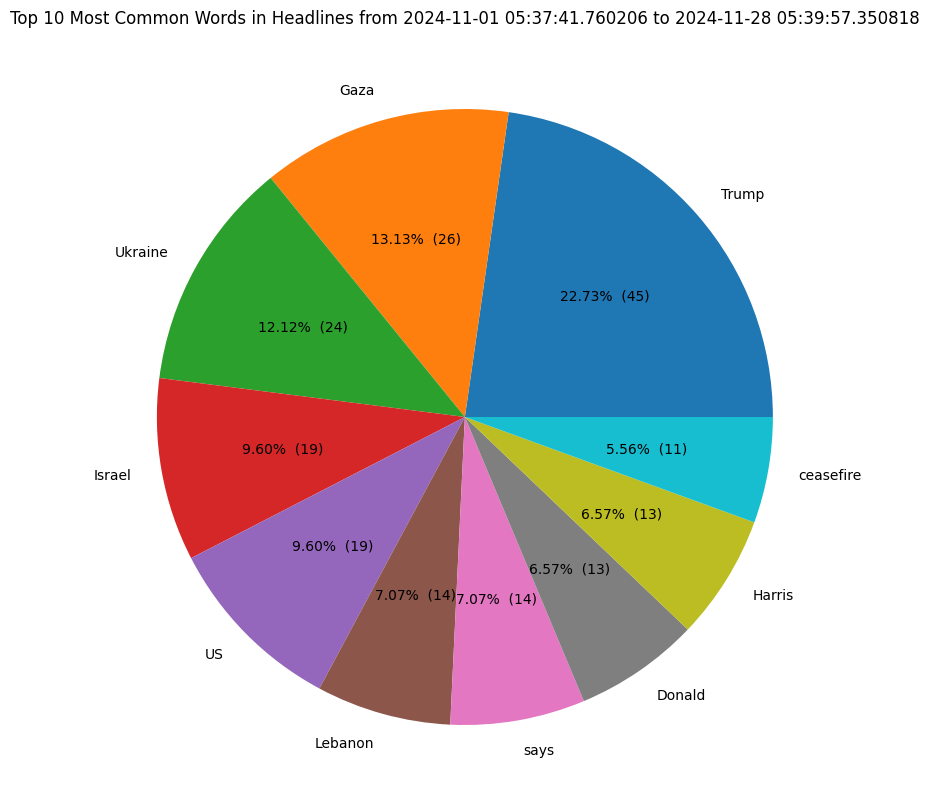

In [247]:
import matplotlib
top_ten = most_common_words_df.head(10)

def add_count(values):
    def add_count_(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return add_count_
pie = top_ten.plot.pie(labels=most_common_words_df['word'], y='count', autopct=add_count(top_ten['count']), figsize=(10, 10))
pie.get_legend().remove()
pie.set_ylabel('')
pie.set_title(f'Top 10 Most Common Words in Headlines from {final_df['scraped_at'].min()} to {final_df['scraped_at'].max()}')

pie.figure.savefig(f'top_10_words_{final_df['scraped_at'].min()}.png')



org                   object
scraped_at    datetime64[ns]
headline_1            object
headline_2            object
headline_3            object
dtype: object
0                   The rise of the truly cruel summer, 
1         The death of Nahel Merzouk: A reconstruction, 
2      BBC tracks down smuggler behind Channel crossi...
3      Israel strikes civilian areas in 24 hours of ‘...
4      What the remaking of Labour reveals about Sir ...
                             ...                        
151    Israeli captive families call on government to...
152    Japan and South Korea are getting friendlier. ...
153        Mexico hit with relentless, deadly heatwave, 
154    Biden unveils Israeli proposal to end Gaza war , 
155    India votes in final phase of giant election a...
Name: headline, Length: 156, dtype: object
                            org                 scraped_at                                         headline_1                                         headline_2           

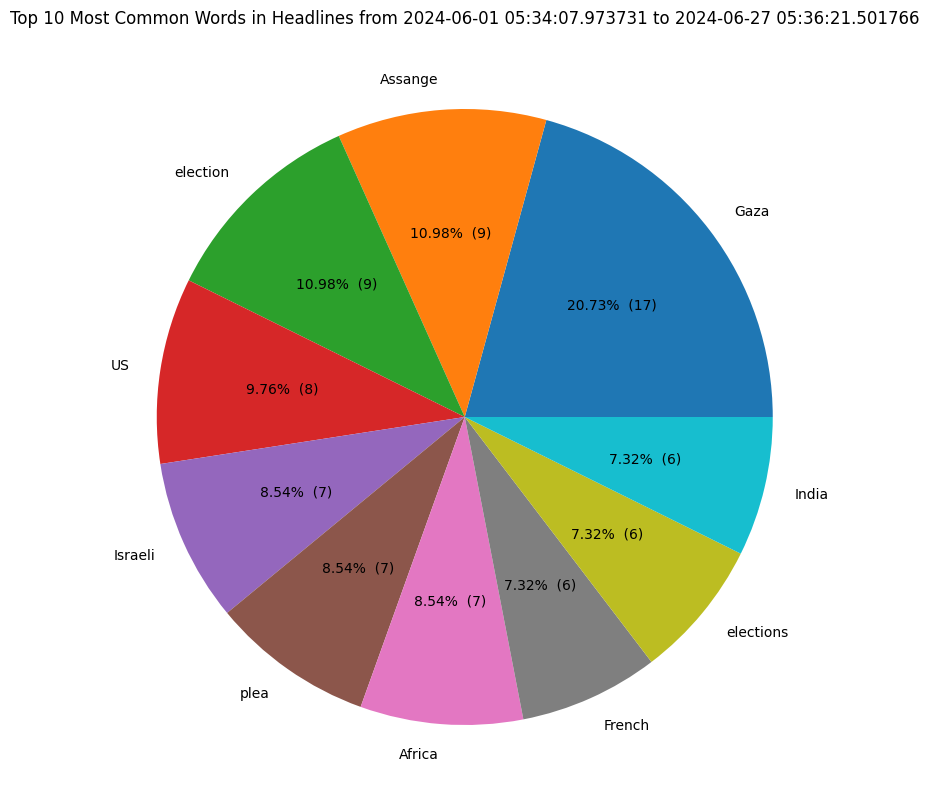

In [261]:
original_df = pd.read_csv('updated_headlines.csv', parse_dates=['scraped_at'])
print(original_df.dtypes)
filtered_june = original_df.loc[(original_df['scraped_at'] >= '2024-06-01') & (original_df['scraped_at'] <= '2024-07-01')]

def transform_dataframe(df):
    df = df.copy()
    df[['headline_1_title', 'headline_1_url']] = df['headline_1'].str.split('https://', n=1, expand=True)
    df[['headline_2_title', 'headline_2_url']] = df['headline_2'].str.split('https://', n=1, expand=True)
    df[['headline_3_title', 'headline_3_url']] = df['headline_3'].str.split('https://', n=1, expand=True)
    df.drop(['headline_1', 'headline_2', 'headline_3'], axis=1)
    for i in ['headline_1_url', 'headline_2_url', 'headline_3_url']:
        df[i] = 'https://' + df[i].astype(str)
    melted = pd.melt(df, id_vars=['org', 'scraped_at'], value_vars=['headline_1_title', 'headline_2_title', 'headline_3_title'], var_name='headline_type', value_name='headline')
    melted_urls = pd.melt(df, id_vars=['org', 'scraped_at'], value_vars=['headline_1_url', 'headline_2_url', 'headline_3_url'], var_name='headline_url', value_name='url')
    melted['url'] = melted_urls['url']
    final_df = melted[['headline', 'url', 'org', 'scraped_at', 'headline_type']]
    final_df['headline_type'] = final_df['headline_type'].str.extract(r'headline_(\d+)_title')
    return final_df

def clean_data(df):
    df['headline'] = df['headline'].apply(lambda x: remove_stopwords(x))
    df['headline'] = df['headline'].apply(lambda x: remove_punct(x))
    df['headline'] = df['headline'].apply(lambda x: remove_stopwords(x))

    return df

def get_most_common_words(df):
    all_headlines = ''.join(df['headline'])     
    words_counts = Counter(word_tokenize(all_headlines))
    most_common_words = words_counts.most_common(20)
    most_common_words_df = pd.DataFrame(most_common_words, columns=['word', 'count'])
    return most_common_words_df

def main(df):
    df = transform_dataframe(df)
    print(df['headline'])
    df = clean_data(df)
    df = get_most_common_words(df)
    df = df[df['word'] != "'"]
    return df

most_common_words_df = main(filtered_june)
most_common_words_df.drop(0, inplace=True)
most_common_words_df.drop(2, inplace=True)

def draw_pie(full_df, common_words_df):
    top_ten = common_words_df.head(10)
    pie = top_ten.plot.pie(labels=common_words_df['word'], y='count', autopct=add_count(top_ten['count']), figsize=(10, 10))
    pie.get_legend().remove()
    pie.set_ylabel('')
    pie.set_title(f'Top 10 Most Common Words in Headlines from {full_df['scraped_at'].min()} to {full_df['scraped_at'].max()}')

draw_pie(filtered_june, most_common_words_df)
print(filtered_june.head())



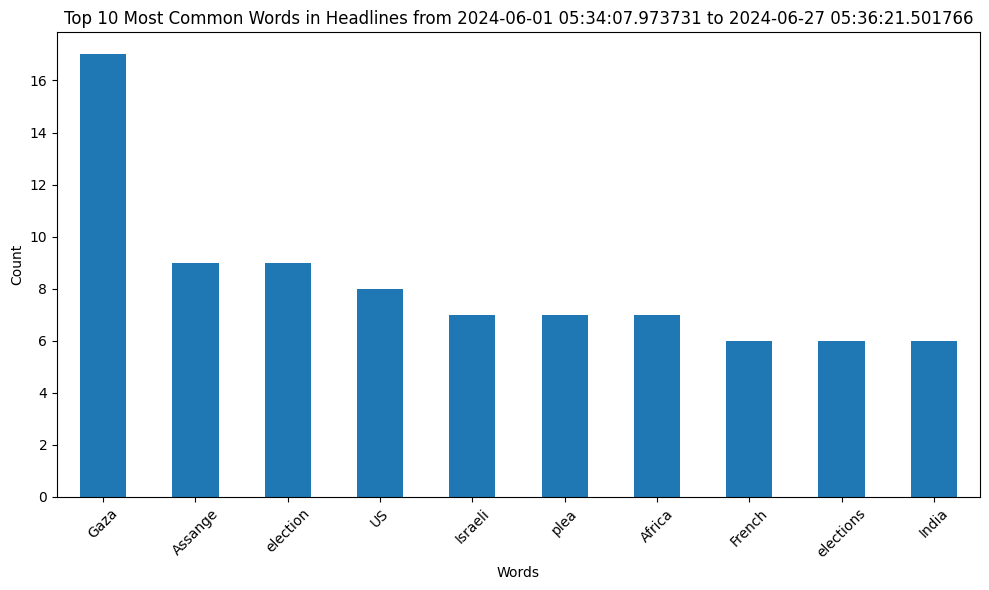

In [ ]:
def draw_bar(full_df, common_words_df):
    top_ten = common_words_df.head(10)
    bar = top_ten.plot.bar(x='word', y='count', legend=False, figsize=(10, 6))
    bar.set_ylabel('Count')
    bar.set_xlabel('Words')
    bar.set_title(f'Top 10 Most Common Words in Headlines from {full_df["scraped_at"].min()} to {full_df["scraped_at"].max()}')
    matplotlib.pyplot.xticks(rotation=45)
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

draw_bar(filtered_june, most_common_words_df)